# SI: Anomalous Fibril Length Dependence on Amyloid Adsorption to Charged Interfaces

_Giulio Tesei, Erik Helstrand, Sara Linse, Emma Sparr, Robert Vacha, Mikael Lund_

### System Requirements
This Jupyter Notebook was originally run in MacOS 10.11 with `GCC 4.8`, `Python2`, `matplotlib`, `pandas` within the Anaconda environment. Contemporary Linux distributions such as Ubuntu 14.04 should work as well.

### Download Faunus; Go to past version; Build custom executable

To simulate the interaction of rigid fibrils with a charged, planar surface we use a custom Metropolis Monte Carlo (MC) program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the complete faunus project and compile the program.

In [1]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

In [2]:
%%bash -s "$workdir"
cd $1
if [ ! -d "faunus/" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
  git checkout dfdddf3
else
  cd faunus
fi
CXX=clang++ CC=clang cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on -DMYPLAYGROUND=`pwd`/../mc/ &>/dev/null
make r2s -j4

Scanning dependencies of target xdrfile
[ 30%] Building C object src/xdrfile/CMakeFiles/xdrfile.dir/xdrfile_xtc.c.o
[ 30%] Building C object src/xdrfile/CMakeFiles/xdrfile.dir/xdrfile.c.o
[ 30%] Building C object src/xdrfile/CMakeFiles/xdrfile.dir/xdrfile_trr.c.o
[ 40%] Linking C static library libxdrfile.a
[ 40%] Built target xdrfile
Scanning dependencies of target libfaunus
[ 60%] Building CXX object src/CMakeFiles/libfaunus.dir/slump.cpp.o
[ 70%] Building CXX object src/CMakeFiles/libfaunus.dir/potentials.cpp.o
[ 60%] Building CXX object src/CMakeFiles/libfaunus.dir/geometry.cpp.o
[ 70%] Building CXX object src/CMakeFiles/libfaunus.dir/species.cpp.o
[ 80%] Building CXX object src/CMakeFiles/libfaunus.dir/analysis.cpp.o
[ 90%] Linking CXX shared library libfaunus.dylib
[ 90%] Built target libfaunus
Scanning dependencies of target r2s
[ 90%] Building CXX object /Users/mikael/github/faunus-notebooks/fibril-surface/mc/CMakeFiles/r2s.dir/rigid2surf.cpp.o
[100%] Linking CXX executable r2s

Cloning into 'faunus'...
Note: checking out 'dfdddf3'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at dfdddf3... Updated non-rejecting cluster move; refined PQR save function; documentation
In file included from /Users/mikael/github/faunus-notebooks/fibril-surface/faunus/src/geometry.cpp:1:
/Users/mikael/github/faunus-notebooks/fibril-surface/faunus/include/faunus/geometry.h:217:16: warning: '_info' overrides a member function but is not marked 'override' [-Winconsistent-missing-override]
        string _info(char); //!< Cylinder info
               ^
/Users/mikael/github/faunus-notebooks/fibril-surface/faunus/include/fa

### Create Input and run MC simulation

In [3]:
%cd $workdir
js = {
  "processes" :
  {
    "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":4.1 },
    "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":4.1 },
    "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":4.1 },
    "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":4.1 },
    "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":4.1 },
    "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":4.1 },
    "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":4.1 },
    "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":4.1 },
    "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":4.1 }
  },

  "atomlist" :
  {
    "Na"   :  { "q": 1, "r":1.9, "mw":22.99 },
    "Cl"   :  { "q":-1, "r":1.7, "mw":35.45 },
    "I"    :  { "q":-1, "r":2.0, "mw":1 },
    "SCN"  :  { "q":-1, "r":2.0, "mw":1 },
    "ASP"  :  { "q":-1, "r":3.6, "mw":110 },
    "HASP" :  { "q":0,  "r":3.6, "mw":110 },
    "LASP" :  { "q":2,  "r":3.6, "mw":110 },
    "CTR"  :  { "q":-1, "r":2.0, "mw":16 },
    "HCTR" :  { "q":0,  "r":2.0, "mw":16 },
    "GLU"  :  { "q":-1, "r":3.8, "mw":122 },
    "HGLU" :  { "q":0,  "r":3.8, "mw":122 },
    "LGLU" :  { "q":2,  "r":3.8, "mw":122 },
    "HIS"  :  { "q":0,  "r":3.9, "mw":130 },
    "HHIS" :  { "q":1,  "r":3.9, "mw":130 },
    "NTR"  :  { "q":0,  "r":2.0, "mw":14 },
    "HNTR" :  { "q":1,  "r":2.0, "mw":14 },
    "TYR"  :  { "q":-1, "r":4.1, "mw":154 },
    "HTYR" :  { "q":0,  "r":4.1, "mw":154 },
    "LYS"  :  { "q":0,  "r":3.7, "mw":116 },
    "HLYS" :  { "q":1,  "r":3.7, "mw":116 },
    "CYS"  :  { "q":-1, "r":3.6, "mw":103 },
    "HCYS" :  { "q":0,  "r":3.6, "mw":103 },
    "ARG"  :  { "q":0,  "r":4.0, "mw":144 },
    "HARG" :  { "q":1,  "r":4.0, "mw":144 },
    "ALA"  :  { "q":0,  "r":3.1, "mw":66 },
    "ILE"  :  { "q":0,  "r":3.6, "mw":102 },
    "LEU"  :  { "q":0,  "r":3.6, "mw":102 },
    "MET"  :  { "q":0,  "r":3.8, "mw":122 },
    "PHE"  :  { "q":0,  "r":3.9, "mw":138 },
    "PRO"  :  { "q":0,  "r":3.4, "mw":90 },
    "TRP"  :  { "q":0,  "r":4.3, "mw":176 },
    "VAL"  :  { "q":0,  "r":3.4, "mw":90 },
    "SER"  :  { "q":0,  "r":3.3, "mw":82 },
    "THR"  :  { "q":0,  "r":3.5, "mw":94 },
    "ASN"  :  { "q":0,  "r":3.6, "mw":108 },
    "GLN"  :  { "q":0,  "r":3.8, "mw":120 },
    "GLY"  :  { "q":0,  "r":2.9, "mw":54 }
  }
}
with open('mc/slitpolymer.json', 'w+') as f:
    f.write(json.dumps(js, indent=4))

def mkinput():
    d = {
        'atomlist':               '../slitpolymer.json',
        'loop_macrosteps':        10,
        'loop_microsteps':        micro,
        'temperature':            298,     # Kelvin
        'epsilon_r':              78.9,    # Water dielectric const
        'dh_ionicstrength':       salt,    # mol/l
        'gouychapman_qarea':      rho,     # unitless i.e. e*phi/kT
        'gouychapman_linearize':  'yes',
        'gouychapman_offset':     3,
        'cuboid_len':             -1, # Box side length Angstrom
        'cuboid_xlen':            2000,
        'cuboid_ylen':            2000,
        'cuboid_zlen':            500,
        'transrot_transdp':       100,     # Molecular translation parameter
        'transrot_rotdp':         6,      # Molecular rotation parameter
        'oligomer':               '../orderedrod.aam',
        'numpep':                 numpep
    }
    f = open('r2s.input', 'w')
    for key,val in d.iteritems():
        f.write('%-30s %s\n' %(key, val))
    f.close()

%cd $workdir'/mc'
micro=20000000
for rho in [266]:
    for salt in [0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 1e10]:
        for numpep in [2, 4, 8, 16, 32, 64, 128]:
            pfx='__rho'+str(rho)+'-N'+str(numpep)+'-I'+str(salt)
            if not os.path.isdir(pfx):
                %mkdir -p $pfx 
                %cd $pfx
                mkinput()
                #!DYLD_LIBRARY_PATH=/Users/mikael/miniconda/lib ../r2s > out
                %cd ..

/Users/mikael/github/faunus-notebooks/fibril-surface
/Users/mikael/github/faunus-notebooks/fibril-surface/mc


### Read all Distribution Functions and Calculate Surface Excess

In [4]:
d = {}
rho=266
for salt in [0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 1e10]:
    d[salt] = {}
    for numpep in [2, 4, 8, 16, 32, 64, 128]:
        pfx='__rho'+str(rho)+'-N'+str(numpep)+'-I'+str(salt)
        
        distfile=pfx+'/cmdist.dat'
        if os.path.isfile(distfile): 
        
            r, P = np.loadtxt(distfile, unpack=True) # load data set
            w = -np.log(P) # potential of mean force (PMF)
        
            # normalize such that w(r)->0 for large r
            m = (r>200) & (r<220)
            if len(w[m])>0:
                w = w - w[m].mean()

                # remove tail
                w = w[r<200]
                r = r[r<200]
            
                # integrate PMF to surface excess
                gamma = np.trapz( np.expm1(-w), r  )
        
                d[salt][numpep] = [r, w, gamma]
    
    if len(d[salt])>0:
        d[salt] = pd.Series(d[salt])

data = pd.DataFrame(d)
data = data.rename(columns={1e10: r'$\infty$'})
data

/Users/mikael/miniconda/lib/python2.7/site-packages/pandas/core/index.py:1122: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,0.06,0.08,0.1,0.15,0.2,0.25,0.27,0.3,$\infty$
2,"[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,...","[[7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6,..."
4,"[[9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, ...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, ...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,...","[[9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, ...","[[9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8,..."
8,"[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14...","[[13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14..."
16,"[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20...","[[19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20..."
32,"[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21...","[[20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21...","[[20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21..."
64,NaN,NaN,"[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22...","[[21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22.2, 22..."
128,NaN,"[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.0, 23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24...","[[23.0, 23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24...","[[23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24..."


### MC: Fibril-surface interaction free energy
This will plot the PMF obtained from MC simulations at different fibril lenghts.

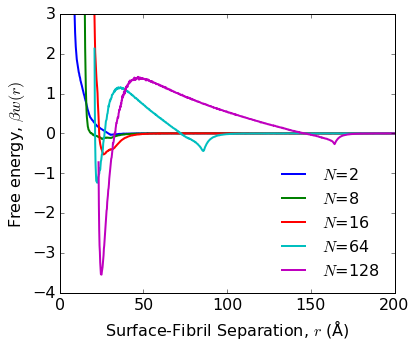

In [5]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})

from scipy.signal import savgol_filter
for N, d in data[0.25].iteritems():
    if N in [2,8,16,64,128]:
        if type(d)!=type(float()):
            plt.plot(d[0], d[1], label='$N$='+str(N), lw=2)
            #plt.plot(d[0], savgol_filter(d[1], 9, 2), lw=2)

plt.legend(loc=0, frameon=False, fontsize='medium')
plt.xlabel('Surface-Fibril Separation, $r$ (Å)')
plt.ylabel(r'Free energy, $\beta w(r)$')
plt.ylim((-4,3))
plt.savefig('mc_pmf.pdf', bbox_inches='tight')

### MC: Surface excess at different salt concentrations and fibril lengths

/Users/mikael/miniconda/lib/python2.7/site-packages/pandas/core/index.py:1759: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)


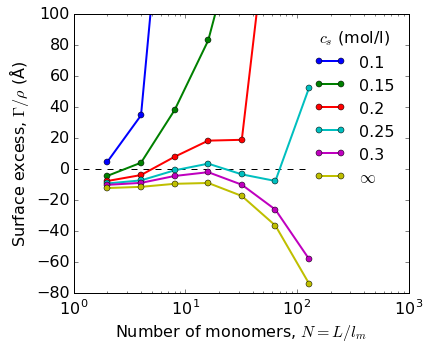

In [6]:
def f(x):
    if type(x)!=type(float()):
        return x[2]
    else:
        return x

plt.plot( [0,128], [0,0], 'k--')

for salt, d in data.iteritems():
    if salt>=0.1 and salt!=0.27:
        _d = d.apply(f)
        plt.plot(_d.keys(), _d.get_values(), label=salt, linestyle='-', marker='o', lw=2, ms=6)

plt.legend(loc=0,frameon=False, fontsize='medium', title=r'$c_{s}$ (mol/l)')
plt.xlabel(r'Number of monomers, $N=L/l_m$')
plt.ylabel(r'Surface excess, $\Gamma/\rho$ (Å)')
plt.xscale('log')
plt.ylim((-80,100))
plt.xlim(1, 1000)
plt.savefig('mc_excess.pdf', bbox_inches='tight')

### Line Segment Model

Here we calculate the surface excess using a simplified model, considering Gouy-Chapman electrostatics and the excluded volume of a rod approaching a planar surface.

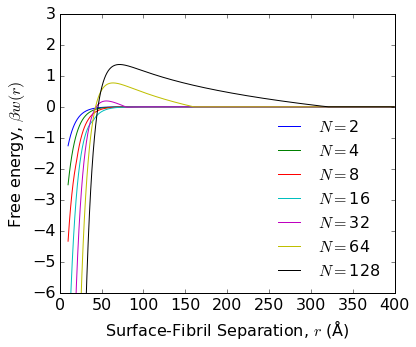

In [7]:
from math import asinh, sqrt, pi
s=10     # closest contact (Å)
lm=5    # monomer length (Å)
zm=2    # monomer charge (e)
lB=7.1  # Bjerrum length (Å)
NA=6.022e23 # Avogadros number (1/mol)

def TdS(r, L):
    """ rod-2-surface excluded volume contribution to free energy (kT) """
    sel = r<0.5*L
    w   = -np.log(2*r[sel]/L)
    return np.concatenate((w, 0*r[~sel]))

for rho in [266]:
    for N in [2,4,8,16,32,64,128]:# number of monomers
        for salt in [0.1]:        # ionic strength (mol/l)
            L = N*lm              # rod length (Å)
            z = zm*N              # rod charge (e)
            lD = 3.04/sqrt(salt)  # Debye length (Å)
            phi = 2*asinh( (1/rho)*sqrt(pi*lB/(2*salt*NA*1e-27)) ) # surf. potential (kT/e)
            r = np.arange(s, 400, 0.5)
            w = -z * phi * np.exp(-(r+s)/lD) + TdS(r,L)
            gamma = np.trapz( np.expm1(-w), r  )
            plt.plot(r, w, label=r'$N=$'+str(N))
            
plt.ylim((-6,3))
plt.legend(loc=0,frameon=False, fontsize='medium')
plt.xlabel('Surface-Fibril Separation, $r$ (Å)')
plt.ylabel(r'Free energy, $\beta w(r)$')

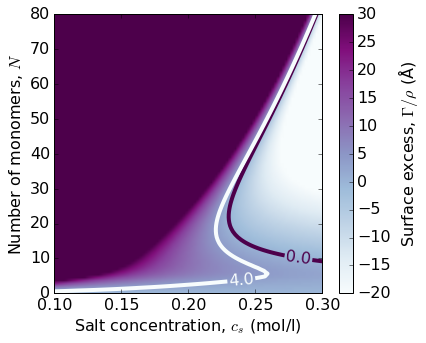

In [8]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.integrate import simps
vmin=-20
vmax=30

x = np.linspace(0.1, 0.3, 100) # salt concentration
y = np.linspace(0.001, 80, 100) # number of monomers
Z = np.ndarray(shape=(y.size,x.size))
rho = 266

for N in y:# number of monomers
    for salt in x:        # ionic strength (mol/l)
         L = N*lm              # rod length (Å)
         z = zm*N              # rod charge (e)
         lD = 3.04/sqrt(salt)  # Debye length (Å)
         phi = 2*asinh( (1/rho)*sqrt(pi*lB/(2*salt*NA*1e-27)) ) # surf. potential (kT/e)
         r = np.arange(s, 1000, 0.2)
         w = -z * phi * np.exp(-(r+s)/lD) + TdS(r,L)
         exc = np.trapz( np.expm1(-w), r  )
         Z[y.tolist().index(N)][x.tolist().index(salt)]=exc

im = imshow(Z,cmap=cm.BuPu, extent=[x.min(), x.max(), y.min(), y.max()],
            origin='lower', aspect='auto', vmin=vmin, vmax=vmax) 

# contour lines
cset = contour(x,y,Z,(0, 4),linewidths=4, cmap=cm.BuPu_r)
manual_locations = [(0.24, 1),(0.28, 2)]
clabel(cset,inline=True,fmt='%1.1f',fontsize=16,manual=manual_locations)

# labels
colorbar(im,label=r'Surface excess, $\Gamma/\rho$ (Å)') # adding the colorbar on the right
plt.ylabel(r'Number of monomers, $N$')
plt.xlabel(r'Salt concentration, $c_s$ (mol/l)')
plt.savefig('linesegment_excess.pdf', bbox_inches='tight')
plt.show()